<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Late_fusion_Attention_based_lesion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


## Read, Split train_val & oversample train set


In [5]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']

df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade
72,IDRiD_073,2
256,IDRiD_257,0
290,IDRiD_291,1
311,IDRiD_312,0
389,IDRiD_390,4


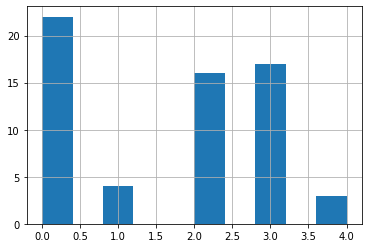

In [6]:
val_df['Retinopathy grade'].hist()

In [8]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 351


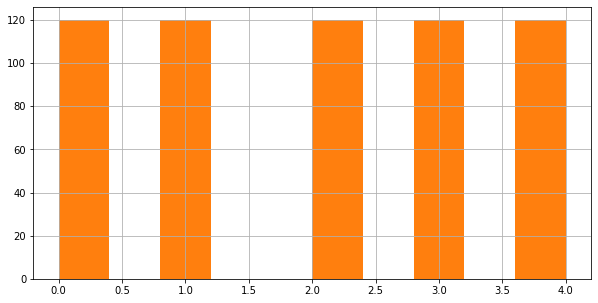

In [9]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [10]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [11]:
image_names = train_df['Image name'];
im_size = 512;

train_labels = [];
for label in train_df['Retinopathy grade']:
    #for i in range(2): # 2 times for data augmentation
    train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((len(train_labels),im_size,im_size,3))

index=0
for image_name in image_names:
    #read image
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index,:,:,:] = img

    #rot 180
    #train_images[index + 1] = np.rot90(np.rot90(img))
    index = index + 1

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  600
(600, 512, 512, 3)
(600, 5)


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    #brightness_range=[0.,0.01],
    #zca_whitening	=True,
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(train_images)

## Read test_df


In [13]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


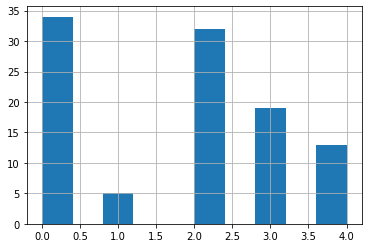

In [14]:
test_df['Retinopathy grade'].hist()

In [15]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = imread(test_images_location + '/' + image_name + ".jpg");
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 512, 512, 3)
(103, 5)


In [16]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of val set ",len(val_image_names))
im_size = 512;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);
print("max value of image ",np.max(val_images))
val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of val set  62
max value of image  255
(62, 512, 512, 3)
(62, 5)


In [17]:
val_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
val_datagen.fit(val_images)

In [18]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (600, 512, 512, 3)
train y size  (600, 5)
test x size  (103, 512, 512, 3)
test y size  (103, 5)
val x size  (62, 512, 512, 3)
val y size  (62, 5)


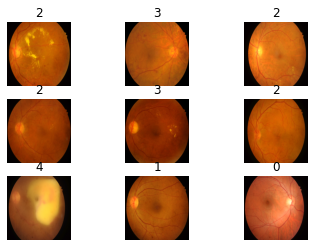

In [19]:
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(train_images[2*i+1])
  plt.title("{}".format(np.argmax(train_labels[2*i+1]))) 
  plt.axis('off')

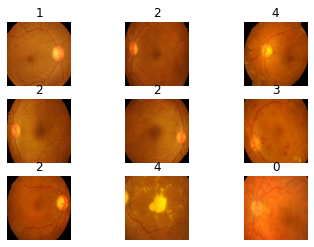

In [20]:
x=train_datagen.flow(train_images, train_labels,batch_size=9,shuffle=True)
for i,(img,lbl) in enumerate(x):
  for j in range(9):
    ax=plt.subplot(3,3,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break
del x

In [24]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [22]:
from tensorflow.keras.models import model_from_json
def load_seg_model(model_name):
    """
    loads the pretrained seg model of given lesion
    """
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/{}.h5".format(model_name))
    # print("Loaded model from disk")

    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [25]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X


In [61]:
def build_model(num_classes,model_name):
    random.seed = 1337
    tf.seed = 1337
    tf.random.set_seed(1337)
    IMG_SIZE=380
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_input')(input_0)
    if model_name=='DenseNet121':
      base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    elif model_name=='EfficientNetB4':
      base_model = EfficientNetB4(include_top=False, input_tensor=input_1*255, weights="imagenet")
    ex_model=load_seg_model("model_EX")
    ma_model=load_seg_model("model_MA")
    se_model=load_seg_model("model_SE")
    he_model=load_seg_model("model_HE_1")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False
    ex_model._name='model_ex'
    ma_model._name='model_ma'
    se_model._name='model_se'
    he_model._name='model_he'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)

    #attention based input
    att=layers.Concatenate(name='concat_lesion')([les_ex,les_se,les_ma,les_he])
    #att= layers.Add(name='lesion_Add')([les_ex,les_se,les_ma,les_he])
    #att=Conv2D(3,3,strides=(1,1),padding='same')(att)
    #att=layers.BatchNormalization(name='0_bn')(att)
    #att=tf.keras.activations.sigmoid(att)
    #f_lesions=layers.Add()([input_0,att])
    
    W_g=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wg')(att)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    #input image
    W_x=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wx')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    # convolve to  attention filter
    att=layers.Add(name='additive_enhance_layer')([W_x,W_g])
    att=tf.keras.activations.relu(att, alpha=0.0, max_value=None, threshold=0)
    att=keras.layers.Conv2D(3, kernel_size=1, padding='same', strides=1)(att)
    att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))
    f_lesions=tf.keras.layers.Multiply()([att,input_0])
    #print(f_lesions.shape)
    #block1
    f_lesions=convolutional_block(f_lesions,3,(3,3,8),1,'1')
    f_lesions=convolutional_block(f_lesions,3,(8,8,16),2,'2')
    f_lesions=convolutional_block(f_lesions,3,(16,16,32),3,'3')
    f_lesions=convolutional_block(f_lesions,3,(32,32,64),4,'4')
    f_lesions=layers.GlobalAveragePooling2D()(f_lesions)
    #print(f_lesions.shape)
    top_dropout_rate = 0.2
    #f_lesions = Dense(256, activation="relu", name="last_dense_1")(f_lesions)
    #f_lesions = Dropout(top_dropout_rate, name="top_dropout_1")(f_lesions)
    #output_1 = Dense(5, activation="softmax", name="pred_1")(f_lesions)
    
    #predection_2
    x=base_model.output
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Concatenate()([x,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    #x = Dense(256, activation="relu", name="last_dense_2")(x)
    x = Dense(NUM_CLASSES, activation="softmax", name="pred_2")(x)

    # Compile
    model = tf.keras.Model(input_0, x, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [62]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model=build_model(5,'EfficientNetB4')

model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled


In [63]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 19,512,689
Trainable params: 29,418
Non-trainable params: 19,483,271


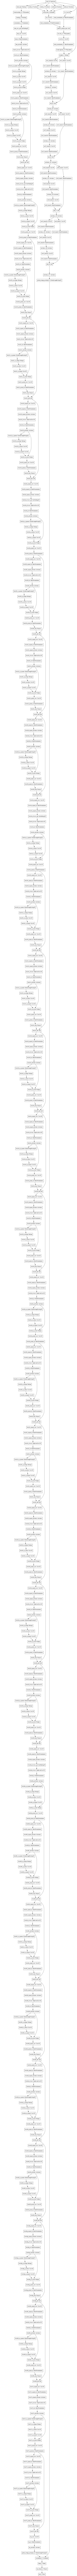

In [64]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [65]:
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',  
                        min_delta=0.01)
#early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 8)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=6,shuffle=True),steps_per_epoch=len(train_images) / 6,
               epochs =100, callbacks = [es,rlr],validation_data=val_datagen.flow(val_images,val_labels,batch_size=8));

Epoch 1/100
100/100 [==============================] - 92s 712ms/step - loss: 1.6542 - accuracy: 0.2237 - val_loss: 1.4625 - val_accuracy: 0.5323
Epoch 2/100
100/100 [==============================] - 65s 651ms/step - loss: 1.4769 - accuracy: 0.3746 - val_loss: 1.4304 - val_accuracy: 0.3710
Epoch 3/100
100/100 [==============================] - 65s 644ms/step - loss: 1.3950 - accuracy: 0.3678 - val_loss: 1.4512 - val_accuracy: 0.2903
Epoch 4/100
100/100 [==============================] - 65s 648ms/step - loss: 1.2829 - accuracy: 0.5313 - val_loss: 1.3982 - val_accuracy: 0.3871
Epoch 5/100
100/100 [==============================] - 65s 649ms/step - loss: 1.2439 - accuracy: 0.4887 - val_loss: 1.3876 - val_accuracy: 0.2742
Epoch 6/100
100/100 [==============================] - 65s 649ms/step - loss: 1.2010 - accuracy: 0.5258 - val_loss: 1.2949 - val_accuracy: 0.4516
Epoch 7/100
100/100 [==============================] - 65s 650ms/step - loss: 1.1364 - accuracy: 0.5678 - val_loss: 1.3130 -

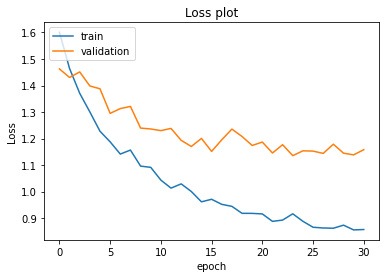

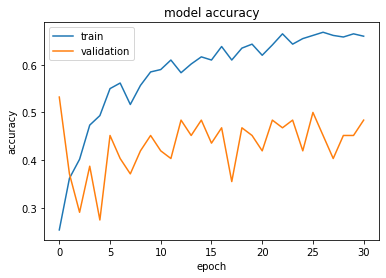

In [66]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
"""es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=8)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4,verbose=1, 
                        mode='auto',min_delta=0.01)
model.trainable=True
opt = keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.8)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=4,shuffle=True),steps_per_epoch=len(train_images) / 4,
               epochs =50, callbacks = [es,rlr],validation_data=val_datagen.flow(val_images,val_labels,batch_size=4));"""

"es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=8)\nrlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \n                        factor=0.5, \n                        patience=4,verbose=1, \n                        mode='auto',min_delta=0.01)\nmodel.trainable=True\nopt = keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.8)\nmodel.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])\nhist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=4,shuffle=True),steps_per_epoch=len(train_images) / 4,\n               epochs =50, callbacks = [es,rlr],validation_data=val_datagen.flow(val_images,val_labels,batch_size=4));"

[[16  2  4  0  0]
 [ 3  1  0  0  0]
 [ 8  1  4  2  1]
 [ 6  1  1  8  1]
 [ 1  0  0  2  0]]
0.46774193548387094  accuracy


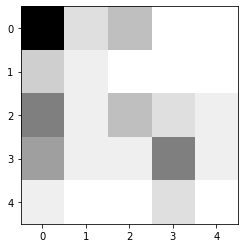

In [67]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_1=np.zeros((val_labels.shape))
#pred_y_2=np.zeros((val_labels.shape))
for i in range(7):
  pred_both=model.predict(val_images[6*i:6*i+6])
  pred_y_1[6*i:6*i+6]=pred_both
  #pred_y_2[6*i:6*i+6]=pred_both[1]
pred_y_=pred_y_1#+pred_y_2
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))," accuracy")

[[12 12 10  0  0]
 [ 2  1  2  0  0]
 [ 3  6 18  4  1]
 [ 1  0  5 11  2]
 [ 2  0  5  2  4]]
0.44660194174757284  acuracy


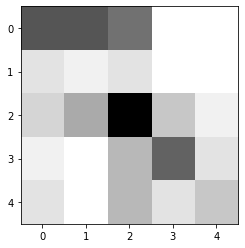

In [68]:
#preds = model.evaluate(test_images, test_labels)
#print("Loss = " + str(preds[0]))
#print("Test accuracy = " + str(preds[1]))
pred_y_=np.zeros((test_labels.shape))
for i in range(18):
  pred_y_[6*i:6*i+6]=model.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

## acc with TTA

In [69]:
test_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
test_datagen.fit(test_images)
pred_y_tta=np.zeros((100,5))
x=test_datagen.flow(test_images,test_labels,batch_size=10)
test_y_=np.zeros((100,5))

[[ 8 17  8  0  0]
 [ 1  2  2  0  0]
 [ 3  5 13  7  2]
 [ 1  1  5 10  2]
 [ 2  0  5  2  4]]
0.37  acuracy


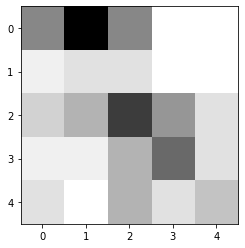

In [70]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[10*i:10*i+10]=model.predict(img)
  test_y_[10*i:10*i+10,:]=lbl
  if i==9:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," acuracy")

In [ ]:
#del test_datagen

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/model_eff_Late_fusion_Attention_based_lesion.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/model_eff_Late_fusion_Attention_based_lesion.h5")
print("Saved model to disk")

## unfreeze and train

In [71]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:] in ['bn','he','ex','se','ma' ]:
    layer.trainable=False
    count+=1

print(count," layers of bn freezed+ 4 seg model freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

100  layers of bn freezed+ 4 seg model freezed
Total params: 19,512,689
Trainable params: 17,452,834
Non-trainable params: 2,059,855


In [72]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
from keras.callbacks import ModelCheckpoint
#filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

opt = keras.optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=6,shuffle=True),steps_per_epoch=len(train_images) / 6,
               epochs = 20,callbacks=[early_stopping],validation_data=val_datagen.flow(val_images,val_labels,batch_size=8));

Epoch 1/20
100/100 [==============================] - 136s 1s/step - loss: 0.9084 - accuracy: 0.6148 - val_loss: 1.1815 - val_accuracy: 0.4677
Epoch 2/20
100/100 [==============================] - 104s 1s/step - loss: 0.7459 - accuracy: 0.7035 - val_loss: 1.0943 - val_accuracy: 0.5161
Epoch 3/20
100/100 [==============================] - 104s 1s/step - loss: 0.6232 - accuracy: 0.7568 - val_loss: 1.1641 - val_accuracy: 0.4194
Epoch 4/20
100/100 [==============================] - 104s 1s/step - loss: 0.5828 - accuracy: 0.7765 - val_loss: 1.0027 - val_accuracy: 0.5484
Epoch 5/20
100/100 [==============================] - 104s 1s/step - loss: 0.4935 - accuracy: 0.8149 - val_loss: 1.0334 - val_accuracy: 0.5161
Epoch 6/20
100/100 [==============================] - 104s 1s/step - loss: 0.4946 - accuracy: 0.8169 - val_loss: 1.1036 - val_accuracy: 0.5161
Epoch 7/20
100/100 [==============================] - 104s 1s/step - loss: 0.4223 - accuracy: 0.8297 - val_loss: 1.2714 - val_accuracy: 0.4839

In [ ]:
model_1=build_model(5,'EfficientNetB0')
model_1.load_weights("weights.best.hdf5")

[[25  3  6  0  0]
 [ 4  0  1  0  0]
 [ 3  3 17  9  0]
 [ 2  0  4 11  2]
 [ 1  0  5  3  4]]


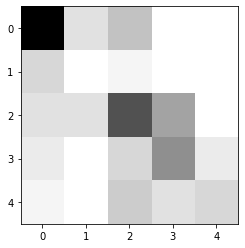

In [79]:
pred_y_=np.zeros((test_labels.shape))
for i in range(11):
  pred_y_[10*i:10*i+10]=model.predict(test_images[10*i:10*i+10])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')

In [80]:
from sklearn.metrics import precision_score,accuracy_score
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

0.5533980582524272  acuracy


In [75]:
del train_images,train_labels
del train_datagen

In [76]:
del x,test_datagen,test_y_,pred_y_tta

In [77]:
test_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
test_datagen.fit(test_images)
pred_y_tta=np.zeros((100,5))
x=test_datagen.flow(test_images,test_labels,batch_size=10)
test_y_=np.zeros((100,5))

[[27  1  5  0  0]
 [ 3  1  1  0  0]
 [ 4  1 20  6  0]
 [ 1  0  7  9  2]
 [ 0  0  5  3  4]]
0.61  accuracy


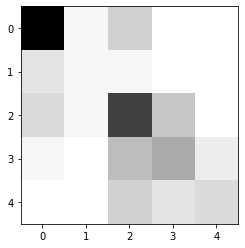

In [78]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[10*i:10*i+10]=model.predict(img)
  test_y_[10*i:10*i+10,:]=lbl
  if i==9:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")